### Speech Recognition Qualification - AY23-2

In [1]:
# Import library yang dibutuhkan
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
# Directory dataset
DATASET_PATH = "data/"
DATA_DIR = pathlib.Path(DATASET_PATH)

In [3]:
# Membuat dataset pelatihan (train_ds) dan dataset vakudasu (val_ds) dari directory audio
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = DATA_DIR,
    batch_size = 64, # Setiap terdiri atas 64 data audio
    validation_split = 0.2, # 20% dari total data akan digunakan sebagai data validasi
    seed = 0,
    output_sequence_length = 16000, # Sampling rate
    subset = "both" # Membuat data pelatihan dan data validasi
)

# Mendapatkan daftar nama kelas dari dataset dan datanya disimpan ke dalam numpy array
label_names = np.array(train_ds.class_names)

Found 41849 files belonging to 30 classes.
Using 33480 files for training.
Using 8369 files for validation.


In [4]:
def squeeze(audio, labels):
    # Menggunakan tf.squeeze untuk menghapus dimensi yang memiliki ukuran 1 dari tensor audio
    audio = tf.squeeze(audio, axis = -1)
    return audio, labels

# Mengaplikasikan fungsi squeeze pada setiap batch dalam dataset pelatihan
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE) # AUTOTUNE = Load data dijalankan secara paralel

# Mengaplikasikan fungsi squeeze pada setiap batch dalam dataset validasi
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE) # AUTOTUNE = Load data dijalankan secara paralel

In [5]:
# 80% Training, 10% Test, 10% Validation
# Membagi dataset validasi menjadi dua bagian menggunakan shard

# Mengambil shard dengan index 0 untuk test_ds
test_ds = val_ds.shard(num_shards = 2, index = 0)

# Mengambil shard dengan index 1 untuk val_ds
val_ds = val_ds.shard(num_shards = 2, index = 1)

In [6]:
for audio, labels in train_ds.take(1):
    # Menggunakan Short-Time Fourier Transform (STFT) untuk menghasilkan spectrogram
    spectrogram = tf.signal.stft(audio, frame_length = 255, frame_step = 128)

    # Absolutein semua magnitudenya
    spectrogram = tf.abs(spectrogram)

    # Retain shape yang sama dan nambahin dimensi baru
    spectrogram = spectrogram[..., tf.newaxis]

In [7]:
def get_spectrogram(audio):
    # Menggunakan Short-Time Fourier Transform (STFT) untuk menghasilkan spectrogram
    spectrogram = tf.signal.stft(audio, frame_length = 255, frame_step = 128)

    # Absolutein semua magnitudenya
    spectrogram = tf.abs(spectrogram)

    # Retain shape yang sama dan nambahin dimensi baru
    spectrogram = spectrogram[..., tf.newaxis]

    # Mengembaliukan spectrogram yang telah diproses
    return spectrogram

In [8]:
# Mapping setiap dataset panggil function get_spectrogram dan labelnya
# Intinya setiap audio di-convert menjadi spectrogram
def make_spec_ds(ds):
    return ds.map(map_func = lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls = tf.data.AUTOTUNE)

In [9]:
# Membuat dataset spectrogram dari dataset pelatihan
train_spectrogram_ds = make_spec_ds(train_ds)

# Membuat dataset spectrogram dari dataset pengujian
test_spectrogram_ds = make_spec_ds(test_ds)

# Membuat dataset spectrogram dari dataset validasi
val_spectrogram_ds = make_spec_ds(val_ds)

In [10]:
# Cache dataset untuk meningkatkan efisiensi pembacaan data
# Mengacak dataset dengan buffer ukuran 10000
# Prefetch batch selanjutnya secara dinamis
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [11]:
# Mengambil satu batch (batch pertama) dari dataset spectrogram pelatihan
for sample_spectrogram, sample_labels in train_spectrogram_ds.take(1):
    break

In [12]:
# Arsitektur dari CNN
input_shape = sample_spectrogram.shape[1:] # Ambil 3 terbelakang buat ukuran shapenya.
num_labels = len(label_names)

# Normalization Layer
norm_layer = layers.Normalization()

# Melakukan adaptasi normalisasi layer menggunakan dataset pelatihan
norm_layer.adapt(data = train_spectrogram_ds.map(map_func = lambda spec, label: spec))

# Membuat model Sequential untuk arsitektur CNN
model = models.Sequential(
    [
        # Lapisan input sesuai dengan ukuran spectrogram
        layers.Input(shape = input_shape), 

        # Lapisan Resizing untuk mengubah ukuran gambar spectrogram menjadi 32x32
        layers.Resizing(32, 32), 

        # Lapisan normalisasi yang telah diadaptasi
        norm_layer, 

        # Proses Convolution dengan 32 filter, ukuran 3x3, dan menggunakan aktivasi ReLU
        # Notes: ReLU = f(x) = max(0, x) -> Jika (-) maka jadi 0
        layers.Conv2D(32, 3, activation = 'relu'), 

        # Proses Convolution dengan 64 filter, ukuran 3x3, dan menggunakan aktivasi ReLU
        # Notes: ReLU = f(x) = max(0, x) -> Jika (-) maka jadi 0
        layers.Conv2D(64, 3, activation = 'relu'),

        # Lapisan MaxPooling untuk mereduksi resolusi gambar
        # Down sample -> resoulsi menjadi lebih kecil. Inti dari gambar tetap masih ada.
        layers.MaxPooling2D(),

        # Lapisan Dropout untuk mencegah overfitting
        layers.Dropout(0.25), 

        # Lapisan Flatten untuk meratakan gambar menjadi satu dimensi
        layers.Flatten(),

        # Lapisan Dense dengan 128 unit dan  menggunakan aktivasi ReLU.
        # Notes: ReLU = f(x) = max(0, x) -> Jika (-) maka jadi 0
        layers.Dense(128, activation = 'relu'),

        # Lapisan Dropout untuk mencegah overfitting
        layers.Dropout(0.5),

        # Lapisan Dense dengan jumlah unit sama dengan jumlah label
        layers.Dense(num_labels)
    ]
)

In [13]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [14]:
# Compile Model
model.compile(
    # Menentukan metrik evaluasi, dalam hal ini menggunakan akurasi
    metrics = ['accuracy'],

    # Menentukan fungsi losses, dalam hal ini menggunakan Sparse Categorical Crossentropy
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),

    # Menentukan optimizer yang digunakan, dalam hal ini menggunakan Adam optimizer
    optimizer = tf.keras.optimizers.Adam()
)

In [15]:
# Proses Model Training
EPOCHS = 10 # Berapa banyak dia akan mengulang trainingnya

history = model.fit(
    # Dataset pelatihan spectrogram
    train_spectrogram_ds,

    # Dataset validasi spectrogram
    validation_data = val_spectrogram_ds,

    # Jumlah epoch atau iterasi training
    epochs = EPOCHS,

    # Penggunaan EarlyStopping untuk menghentikan pelatihan jika tidak ada peningkatan 
    # signifikan pada metrik validasi selama beberapa epoch
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
524/524 [==============================] - 53s 98ms/step - loss: 1.2337 - accuracy: 0.6405 - val_loss: 0.3386 - val_accuracy: 0.9055
Epoch 2/10
524/524 [==============================] - 35s 68ms/step - loss: 0.4687 - accuracy: 0.8519 - val_loss: 0.1820 - val_accuracy: 0.9538
Epoch 3/10
524/524 [==============================] - 39s 74ms/step - loss: 0.3037 - accuracy: 0.9033 - val_loss: 0.1203 - val_accuracy: 0.9683
Epoch 4/10
524/524 [==============================] - 39s 74ms/step - loss: 0.2293 - accuracy: 0.9265 - val_loss: 0.0997 - val_accuracy: 0.9738
Epoch 5/10
524/524 [==============================] - 40s 77ms/step - loss: 0.1846 - accuracy: 0.9400 - val_loss: 0.0865 - val_accuracy: 0.9774
Epoch 6/10
524/524 [==============================] - 39s 75ms/step - loss: 0.1529 - accuracy: 0.9491 - val_loss: 0.0691 - val_accuracy: 0.9800
Epoch 7/10
524/524 [==============================] - 38s 73ms/step - loss: 0.1316 - accuracy: 0.9564 - val_loss: 0.0704 - val_accuracy:

Text(0, 0.5, 'Accuracy [%]')

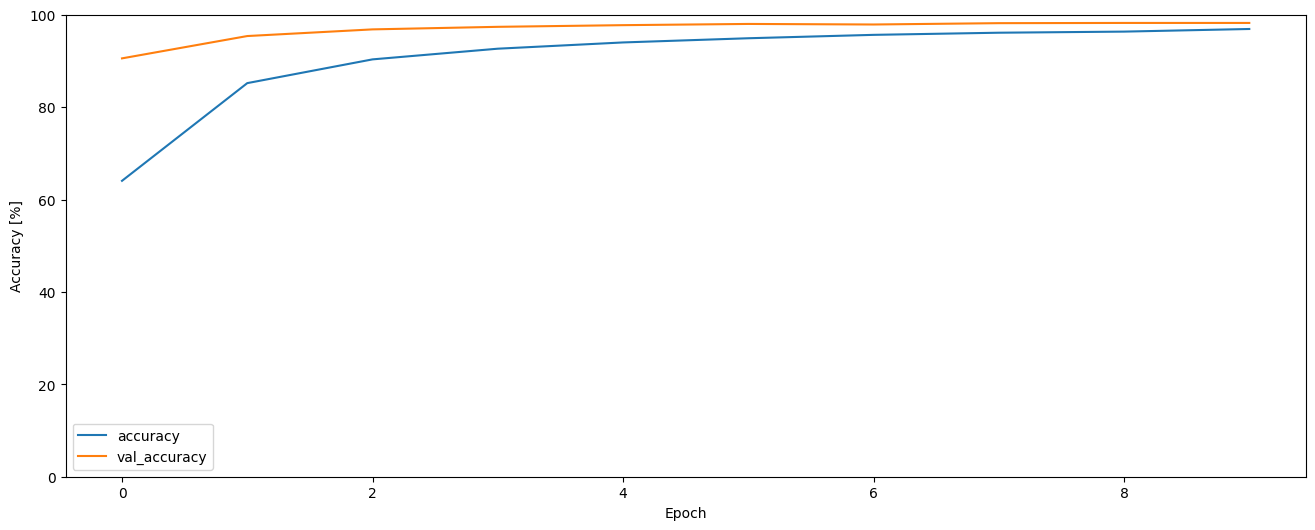

In [16]:
# Mendapatkan metrik dari history pelatihan
metrics = history.history

# Membuat gambar plot dengan ukuran 16x6.
plt.figure(figsize = (16, 6))

# Membuat plot dari metrik akurasi pada setiap epoch untuk pelatihan dan validasi
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))

# Menambahkan legenda ke plot
plt.legend(['accuracy', 'val_accuracy'])

# Menetapkan rentang sumbu y dari nilai 0 hingga 100
plt.ylim([0, 100])

# Menetapkan label sumbu x sebagai "Epoch"
plt.xlabel("Epoch")

# Menetapkan label sumbu y sebagai "Accuracy [%]"
plt.ylabel("Accuracy [%]")

In [17]:
# Menggunakan model untuk melakukan prediksi pada dataset spectrogram pengujian
y_pred = model.predict(test_spectrogram_ds)

# Mengambil indeks dengan nilai terbesar (argmax) sebagai prediksi
y_pred = tf.argmax(y_pred, axis = 1)

66/66 [==============================] - 13s 193ms/step


In [18]:
# Function untuk mengonversi indeks label menjadi label string
def convert_to_label(labels):
    return [label_names[label.numpy()] for label in labels]

# Mengonversi prediksi menjadi label string
y_pred = convert_to_label(y_pred)

# Mengonversi label sebenarnya dari dataset pengujian menjadi label string
y_true = convert_to_label(tf.concat([label for _, label in test_spectrogram_ds], axis = 0)) # Ambil labelnya saja

# Iterasi dan mencetak label sebenarnya dan prediksi untuk setiap data yang ada
for idx, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
    print(f"Data {idx}: Original Label {true_label}, Prediction {pred_label}")

Data 0: Original Label zero, Prediction zero
Data 1: Original Label sheila, Prediction sheila
Data 2: Original Label eight, Prediction eight
Data 3: Original Label three, Prediction three
Data 4: Original Label marvel, Prediction marvel
Data 5: Original Label right, Prediction right
Data 6: Original Label bed, Prediction bed
Data 7: Original Label tree, Prediction tree
Data 8: Original Label marvel, Prediction marvel
Data 9: Original Label wow, Prediction on
Data 10: Original Label marvel, Prediction marvel
Data 11: Original Label stop, Prediction stop
Data 12: Original Label wow, Prediction wow
Data 13: Original Label stop, Prediction stop
Data 14: Original Label dog, Prediction dog
Data 15: Original Label zero, Prediction zero
Data 16: Original Label go, Prediction go
Data 17: Original Label up, Prediction up
Data 18: Original Label go, Prediction go
Data 19: Original Label house, Prediction house
Data 20: Original Label happy, Prediction happy
Data 21: Original Label three, Predicti

In [20]:
# Test Accuracy
# Mengonversi menjadi numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Menghitung akurasi dengan membandingkan label sebenarnya dan prediksi
accuracy = np.mean(y_true == y_pred)

# Print tingkat accuracy-nya
print("Accuracy on test set: ", accuracy) 

Accuracy on test set:  0.9793300071275838
